In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('csv',data_files='dataset_sentenceattribution_nerfeatures_split.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","gem_exp","gem_label","gpt_label","gpt_exp","gold_exp","entity_map_ev","entity_ev","synonym","voice","split"],skiprows=1)

Using custom data configuration default-cfbf7584a6bb7c13
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 220.02it/s]


In [3]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-aa1fd4d2889f655e.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-9cd628f4430f2ace.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-df968f39da4ad12a.arrow


In [4]:
columns_to_keep = ["claim", "premise", "label", "category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 234
    })
})

In [6]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)

# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-b638575a29a2a369.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-c40e649fdc04fbe6.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-b1db050fd6262d30.arrow


Label Encoding Mapping: {'contradiction': 2, 'entailment': 0, 'neutral': 1}


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 234
    })
})

In [8]:
labels = np.array(dataset['train']['label'])

In [9]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts
        claim = item['claim'] 
        evidences = item['premise']
        item['premise']=evidences
        item['claim']=claim
        additional_features = [
            "count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
    
        for feature in additional_features:
            if feature in item:
                claim += "[SEP]" + str(item[feature])
        # Tokenize the texts
        inputs = self.tokenizer(
            evidences,claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
         # Construct the output item
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': evidences  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item



In [10]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [11]:
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1}

In [13]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
    num_rows: 1623
})

In [14]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [15]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [16]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [17]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [18]:
tdata.__getitem__(0)

{'input_ids': tensor([    1,  4081,   261,  5042,   333, 73325,  1452,  2155,  6116,  1938,
           272,   262, 88609,   263, 98237,  1830,  1080,  7355,   387,  2655,
           262, 12682,   265, 65008,   292,  1158, 53245,   264, 75840,   293,
          2376,  1158,  1452,  2155,   260,     2,   573, 52341,  1830,  1080,
           269,  1359,   427,   267, 17847,   633,   264,   408,  1300,   262,
          2658,   265,   262,  1158,   260,     2,   767,     2,   767,     2,
           767,     2,   767,     2,   767,     2,   767,     2,   767,     2,
           767,     2,   767,     2,   767,     2,   767,     2,   767,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [19]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/2.1.3_deberta/',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.6,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/2.1.3_deberta/best_model')
tokenizer.save_pretrained(f'/home/elson/2.1.3_deberta/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 765


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.719700,0.823577,0.645161,0.605207,0.645161,0.594127
2,0.666400,0.773161,0.679570,0.673637,0.679570,0.676050
3,0.479600,0.800578,0.692473,0.696010,0.692473,0.691663
4,0.333100,0.957869,0.675269,0.670232,0.675269,0.672543
5,0.327600,1.081264,0.666667,0.682322,0.666667,0.672219
6,0.210300,1.353984,0.683871,0.703216,0.683871,0.689833
7,0.207400,1.307299,0.658065,0.683555,0.658065,0.665743
8,0.159900,1.441404,0.675269,0.683206,0.675269,0.675515
9,0.151800,1.363435,0.683871,0.704333,0.683871,0.689063
10,0.175300,1.553594,0.668817,0.689560,0.668817,0.673795


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/2.1.3_deberta/checkpoint-51
Configuration saved in /home/elson/2.1.3_deberta/checkpoint-51/config.json
Model weights saved in /home/elson/2.1.3_deberta/checkpoint-51/pytorch_model.bin
Deleting older checkpoint [/home/elson/2.1.3_deberta/checkpoint-306] due to args.save_total_limit
Deleting older checkpoint [/home/elson/2.1.3_deberta/checkpoint-765] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/2.1.3_deberta/checkpoint-102
Configuration saved in /home/elson/2.1.3_deberta/checkpoint-102/config.json
Model weights saved in /home/elson/2.1.3_deberta/checkpoint-102/pytorch_model.bin
Deleting older checkpoint [/home/elson/2.1.3_deberta/checkpoint-51] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/2.1.3_deb

Configuration saved in /home/elson/2.1.3_deberta/best_model/config.json
Model weights saved in /home/elson/2.1.3_deberta/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/2.1.3_deberta/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/2.1.3_deberta/best_model/special_tokens_map.json
added tokens file saved in /home/elson/2.1.3_deberta/best_model/added_tokens.json


('/home/elson/2.1.3_deberta/best_model/tokenizer_config.json',
 '/home/elson/2.1.3_deberta/best_model/special_tokens_map.json',
 '/home/elson/2.1.3_deberta/best_model/spm.model',
 '/home/elson/2.1.3_deberta/best_model/added_tokens.json')

In [20]:
model_path = "/home/elson/2.1.3_deberta/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/2.1.3_deberta/best_model/config.json
Model config DebertaV2Config {
  "_name_or_path": "/home/elson/2.1.3_deberta/best_model/",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,

In [21]:
print(test_results)

PredictionOutput(predictions=array([[ 2.1328e+00,  7.3779e-01, -2.8828e+00],
       [ 3.1914e+00, -2.5195e-01, -2.9277e+00],
       [ 3.0059e+00, -5.7666e-01, -2.3770e+00],
       [-3.0933e-01,  7.8662e-01, -4.6118e-01],
       [ 2.7949e+00, -2.9858e-01, -2.4082e+00],
       [ 3.2383e+00, -3.3374e-01, -2.8496e+00],
       [ 2.5703e+00, -3.9941e-01, -2.1641e+00],
       [ 3.3574e+00, -8.9893e-01, -2.3750e+00],
       [ 2.6094e+00, -8.1909e-02, -2.4707e+00],
       [ 3.9380e-01,  1.3340e+00, -1.7627e+00],
       [-9.6826e-01, -2.7771e-02,  1.0811e+00],
       [ 3.9453e+00, -1.2080e+00, -2.5859e+00],
       [ 2.6318e-01,  9.6631e-01, -1.1895e+00],
       [ 3.6992e+00, -9.6533e-01, -2.5957e+00],
       [-7.6562e-01,  1.6719e+00, -8.8184e-01],
       [-8.1396e-01,  9.7754e-01, -3.6499e-02],
       [ 1.2861e+00,  1.5557e+00, -3.0332e+00],
       [ 3.5791e-01,  2.6807e-01, -6.0693e-01],
       [ 3.7168e+00, -9.3750e-01, -2.6504e+00],
       [ 2.4922e+00,  1.0229e-01, -2.6172e+00],
       [ 1.

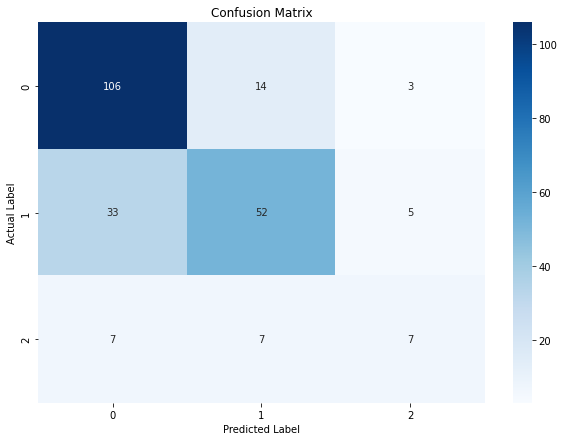

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [23]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/2.1.3_results.csv', index=False)

In [24]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [25]:
correct_classification_counts

General Health           40
Bone health              17
Skin                     15
Cancer                   12
Fitness                  11
Diabetes                 10
Cardiovascular Health     7
Ear                       6
Throat                    6
Neurological health       6
Hair                      5
Blood                     5
Eye                       5
COVID                     5
Muscles                   4
Men's health              3
Mental Health             3
Women' s Health           2
Vascular                  2
Dental Health             1
Name: Category, dtype: int64

In [26]:
misclassification_counts

General Health           11
Skin                      9
Hair                      7
Cardiovascular Health     5
Women' s Health           4
Eye                       4
Fitness                   4
Bone health               4
Blood                     4
Neurological health       3
Men's health              3
Throat                    3
Diabetes                  2
Dental Health             2
Muscles                   2
COVID                     1
Vascular                  1
Name: Category, dtype: int64